In [7]:
#!pip install biopython pandas torch scikit-learn transformers datasets accelerate

In [1]:
import os
from Bio import SeqIO
import pandas as pd
from sklearn.model_selection import train_test_split

def load_fasta(file_path):
    """Loads sequences from a FASTA file."""
    sequences = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append({"id": record.id, "sequence": str(record.seq)})
    return pd.DataFrame(sequences)

# Load the datasets
tf_df = load_fasta("input/TF.fasta")
tsp_df = load_fasta("input/TSP.fasta")
nonrbp_df = load_fasta("input/nonRBPs.fasta")

# Add labels
tf_df["label"] = 1
tsp_df["label"] = 2
nonrbp_df["label"] = 0

# Extract cluster IDs for TF dataframe
tf_df['cluster_id'] = tf_df['id'].apply(lambda x: x.split('_')[-1])

In [2]:
nonrbp_df = nonrbp_df.sample(frac=0.03, random_state=42)

In [3]:
# Identify single-member clusters in the TF dataset
cluster_counts = tf_df['cluster_id'].value_counts()
single_member_clusters = cluster_counts[cluster_counts == 1].index
multi_member_clusters = cluster_counts[cluster_counts > 1].index

tf_single_member_df = tf_df[tf_df['cluster_id'].isin(single_member_clusters)]
tf_multi_member_df = tf_df[tf_df['cluster_id'].isin(multi_member_clusters)]

# Split the multi-member cluster data, stratifying by cluster_id
tf_train_multi, tf_test = train_test_split(
    tf_multi_member_df,
    test_size=0.2,
    stratify=tf_multi_member_df['cluster_id'],
    random_state=42
)

# The training set for TFs is the combination of the multi-member training split and all single-member clusters
tf_train = pd.concat([tf_train_multi, tf_single_member_df])

# Perform standard train-test splits for TSP and nonRBP
tsp_train, tsp_test = train_test_split(tsp_df, test_size=0.2, random_state=42)
nonrbp_train, nonrbp_test = train_test_split(nonrbp_df, test_size=0.2, random_state=42)

# Combine the training and testing sets
train_df = pd.concat([tf_train, tsp_train, nonrbp_train]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([tf_test, tsp_test, nonrbp_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))
print("\nTraining set label distribution:\n", train_df['label'].value_counts())
print("\nTesting set label distribution:\n", test_df['label'].value_counts())

Training set size: 10979
Testing set size: 2745

Training set label distribution:
 label
0    9741
2     675
1     563
Name: count, dtype: int64

Testing set label distribution:
 label
0    2436
2     169
1     140
Name: count, dtype: int64


In [4]:
from transformers import AutoTokenizer, EsmForSequenceClassification

model_name = "facebook/esm2_t12_35M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EsmForSequenceClassification.from_pretrained(model_name, num_labels=3)

/home/victor/miniconda3/envs/esm2classifier/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
import torch
from torch.utils.data import Dataset

class ProteinDataset(Dataset):
    def __init__(self, sequences, labels, tokenizer):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(sequence, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = ProteinDataset(train_df['sequence'].tolist(), train_df['label'].tolist(), tokenizer)
test_dataset = ProteinDataset(test_df['sequence'].tolist(), test_df['label'].tolist(), tokenizer)

In [6]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

/home/victor/miniconda3/envs/esm2classifier/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.092800,0.130821,0.959927,0.957861,0.961030,0.959927
2,0.027700,0.074984,0.982149,0.981954,0.981984,0.982149
3,0.041700,0.051462,0.988342,0.988417,0.988542,0.988342


/home/victor/miniconda3/envs/esm2classifier/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/victor/miniconda3/envs/esm2classifier/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/victor/miniconda3/envs/esm2classifier/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/victor/miniconda3/envs/esm2classifier/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and re

TrainOutput(global_step=1032, training_loss=0.17332668968498013, metrics={'train_runtime': 268.0133, 'train_samples_per_second': 122.893, 'train_steps_per_second': 3.851, 'total_flos': 3388196394233856.0, 'train_loss': 0.17332668968498013, 'epoch': 3.0})

In [8]:
results = trainer.evaluate()
print("\nFinal Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")

/home/victor/miniconda3/envs/esm2classifier/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Final Evaluation Results:
eval_loss: 0.05146161839365959
eval_accuracy: 0.9883424408014572
eval_f1: 0.9884166382039802
eval_precision: 0.9885417774941354
eval_recall: 0.9883424408014572
eval_runtime: 11.0071
eval_samples_per_second: 249.384
eval_steps_per_second: 7.813
epoch: 3.0


/home/victor/miniconda3/envs/esm2classifier/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


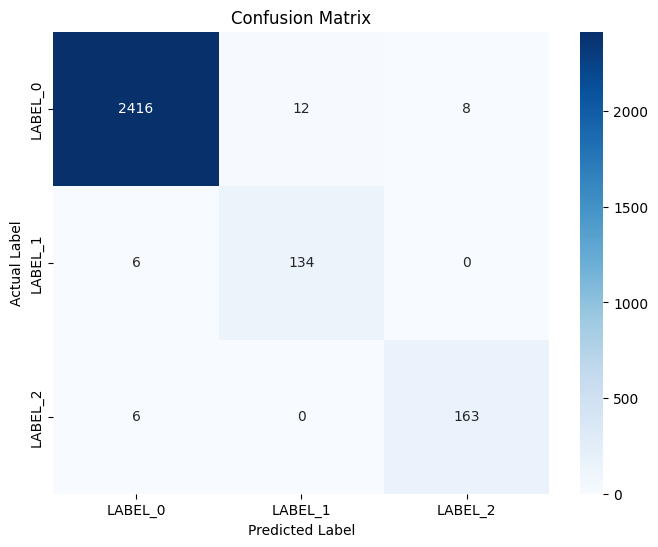

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class names based on the model's id2label mapping
class_names = list(model.config.id2label.values())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [10]:
# After trainer.train() has finished
final_model_path = "./final_esm2_classifier"
trainer.save_model(final_model_path)
print(f"Final model saved to {final_model_path}")

Final model saved to ./final_esm2_classifier


In [11]:
tokenizer.save_pretrained(final_model_path)

('./final_esm2_classifier/tokenizer_config.json',
 './final_esm2_classifier/special_tokens_map.json',
 './final_esm2_classifier/vocab.txt',
 './final_esm2_classifier/added_tokens.json')